In [1]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


import tempfile
import time
import pickle as pkl;

import data.constants.constants as constants

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [2]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 4# was 64
batch_size_test = 4
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = './data/saved_models/' + 'all_diseases_all_imgs' + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4}

In [4]:
pkl_load = open('dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [5]:
# transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
# #0 = train, 1 = test
# dataset_train = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 0, transforms)
# dataset_valid = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 1, transforms)
# dataset_test = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
#                           num_imgs, tt_factor, 2, transforms)
# print(len(dataset_train))
# print(len(dataset_valid))
# print(len(dataset_test))

In [6]:
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True, num_workers=1)
# valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
# print(len(train_loader))
# print(len(valid_loader))
# print(len(test_loader))

In [10]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid(),
])
model = torch.nn.DataParallel(model)

In [10]:
state_dict = torch.load(model_path)

In [12]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    new_state_dict['module.' + k] = state_dict[k]

In [21]:
t = torch.load(model_path)

In [8]:
from collections import OrderedDict


def gen_state_dict(model_path):
    state_dict = torch.load(model_path)
    first_key = list(state_dict.keys())[0]
    if first_key[0:7] != 'module':
        new_state_dict = OrderedDict()
        for k,v in state_dict.items():
            new_state_dict['module.' + k] = state_dict[k]
        return new_state_dict
    else:
        return state_dict

In [9]:
model.load_state_dict(new_state_dict)

NameError: name 'model' is not defined

In [16]:
#network = model
#network = torchvision.models.vgg11(pretrained=False)
#network.fc = nn.Linear(512, 15)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Trainable params: 11179590


In [12]:
class ResNet(nn.Module):
    def __init__(self, model_file):
        super(ResNet, self).__init__()
        
        self.model_file = model_file
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=6, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(gen_state_dict(self.model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [13]:
gmodel = ResNet(model_path)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [14]:
gmodel.load_weights()
print('weights loaded successfully')

weights loaded successfully


In [15]:
def check_contains(b1, b2):
    lx = b1['low_x'] <= b2['low_x']
    ly = b1['low_y'] <= b2['low_y']
    hx = b1['high_x'] >= b2['high_x']
    hy = b1['high_y'] >= b2['high_y']
    
    return lx and ly and hx and hy


In [16]:
def check_too_big(b):
    w = b['high_x'] - b['low_x']
    h = b['high_y'] - b['low_y']
    
    return w * h > 350000 # roughly if box is larger than 1/3 of the image then get rid of it

In [17]:
def compute_dist(b, avg):
    x = b['high_x'] - b['low_x']
    y = b['high_y'] - b['low_y']
    return abs(x * y - avg)

In [18]:
def compute_weight_score(b, heatmap, disease_avg):
    lx = b['low_x']
    ly = b['low_y']
    hx = b['high_x']
    hy = b['high_y']
    
    
    area = (hx - lx) * (hy - ly)
    distance = abs(area - disease_avg)
    
    # average value of the square divided by distance from average size for this disease type
    avg_pixel_val = np.sum(heatmap[ly:hy, lx:hx]) / (area)
    score = avg_pixel_val / distance * 100
    
    #print('score: ', score, 'vals: ', lx, hx, ly, hy)
    return score
    
#     score = 0
#     for row in range(ly, hy):
#         prevscore = score
#         score += np.sum(heatmap[row][lx, hx+1])
#         if prevscore == score:
#             print('no change: ', heatmap[row][lx, hx+1], 'lx ly hx hy:', lx, ly, hx, hy )
        
#     return score
    

In [19]:
def get_bboxes(label_map, heatmap, disease):
    uniques = np.unique(label_map)
    boxes = {} # stored as x1, x2, y1, y2
    
    #explore_map = copy.deepcopy()
    
    #plt.imshow(heatmap)
    #plt.title('bbox label map in method')
    #plt.figure()
    
    for u in uniques:
        low_x = 9999
        low_y = 9999
        high_x = -1
        high_y = -1
        
        for r in range(len(label_map)):
            for c in range(len(label_map[0])):
                
                cur = label_map[r][c]
                
                if cur == u:
                    low_x = min(low_x, c)
                    low_y = min(low_y, r)
                    high_x = max(high_x, c)
                    high_y = max(high_y, r)
                    
                    #explore_map = 1
                    
        boxes[u] = {'low_x' : low_x, 'low_y' : low_y,
                        'high_x' : high_x, 'high_y' : high_y}
     
    # step 1: remove the boxes that are too big    
    boxes_temp = copy.deepcopy(boxes)
    for k, b in boxes.items():
        if check_too_big(b):
            boxes_temp.pop(k, None)
            
    boxes = boxes_temp
    
    # step 2: remove boxes that are contained in other boxes
#     boxes_temp = copy.deepcopy(boxes)

#     for k1, b1 in boxes.items():
#         for k2, b2 in boxes.items():
#             if k1 != k2 and check_contains(b1,b2):
#                 boxes_temp.pop(k2, None)
                    
#     boxes = boxes_temp
#     boxes_temp = {}
    
    # step 3: select the 3 boxes with the size closest to that of the average box size for this disease (based on training data)
    avg_size = constants.BBOX_AVG_SIZE[disease]
    
    box_dist_from_avg = {}
    best_boxes = {}
    for k, b in boxes.items():
        box_dist_from_avg[k] = compute_dist(b, avg_size)
        
    box_dist_from_avg = {k : v for k, v in sorted(box_dist_from_avg.items(), key=lambda x: x[1])}
    
    for i, k in enumerate(box_dist_from_avg.keys(), 1):
        best_boxes[k] = boxes[k]
        
        if i == 5: # take only the best 3
            break
                
    boxes = best_boxes
    #print(box_dist_from_avg)
    
    # step 4: use threshold values to give value to boxes based on how active it is
    box_weight_score = {}
    best_boxes = {}

    for k, b in boxes.items():
        box_weight_score[k] = compute_weight_score(b, heatmap, avg_size)
        
    box_weight_score = {k : v for k, v in sorted(box_weight_score.items(), key=lambda x: -x[1])}

    for i, k in enumerate(box_weight_score.keys(), 1):
        best_boxes[k] = boxes[k]
        
        if i == 3: # take only the best 3
            break
            
    boxes = best_boxes
    
    #print(box_weight_score)
    #step 5: reset the keys on the boxes, for ex:  [5, 7, 11] --> [0, 1, 2]

    boxes_temp = {}
    idx = 0
    for k in boxes.keys():
        boxes_temp[idx] = boxes[k]
        idx += 1
        
    boxes = boxes_temp
        
    #print(boxes)
    #print('\n boxes delivered: \n', boxes)
    return boxes

In [352]:
def convert_to_rgb(np_arr):
    img = np.uint8(np.interp(np_arr, (np_arr.min() * 1/5, np_arr.max()), (0, 255)))
    img = cv2.applyColorMap(img, cv2.COLORMAP_HOT)
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    
    return img

In [369]:
def get_grad_map(data, model, disease):
    img_path = './data/sorted_images/' + data['disease'] + '/' + data['view'] + '/' + data['img_name']

    transform = torchvision.transforms.ToTensor()
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img.shape
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    grad_activations = heatmap
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    
    colormap = cv2.resize(np.float32(grad_activations), (1024, 1024), interpolation=cv2.INTER_CUBIC)
    colormap = convert_to_rgb(colormap)
    
    plt.figure()
    plt.imshow(colormap)

    superimposed_img = colormap * 0.5 + img * 0.5
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 120 #* heatmap.mean()
        
    all_labels = measure.label(blobs)
    
    return all_labels, heatmap, grad_activations

In [370]:
def calc_iobb(data, model, disease):
    label_map, heatmap, _ = get_grad_map(data, model, disease)
    
    boxes = get_bboxes(label_map, heatmap, disease)
    
    
    single_level = np.array(label_map >= 1, dtype='int')
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    real_box = np.zeros((1024, 1024), dtype='int')
    x = int(data['x'])
    y = int(data['y'])
    width = int(data['width'])
    height = int(data['height'])
    for xi in range(x, x + width):
        for yi in range(y, y + height):
            real_box[yi][xi] = 1

    pred_boxes = np.zeros((1024, 1024), dtype='int')
    for _, b in boxes.items():
        for xi in range(b['low_x'], b['high_x']+1):
            for yi in range(b['low_y'], b['high_y']+1):
                pred_boxes[yi][xi] = 1
                
#     plt.figure()
#     plt.imshow(real_box)
#     plt.figure()
#     plt.imshow(pred_boxes)
    return jaccard_score(real_box.flatten(), pred_boxes.flatten())
    

In [371]:
def bbox_main(data, model, disease):
        
    all_labels, heatmap, grad_activations = get_grad_map(data, model, disease)
    
    grad_img = convert_to_rgb(grad_activations)

    plt.figure() 
    plt.imshow(grad_img)
    plt.title('grad map')

    heattest = cv2.resize(np.float32(grad_activations), (1024, 1024), interpolation=cv2.INTER_CUBIC)#, interpolation=cv2.INTER_LANCZOS4)
    heattest = convert_to_rgb(heattest)

    plt.figure()
    plt.imshow(heattest)
    plt.figure()
    #plt.savefig('grad_threshold')
    
    boxdict = get_bboxes(all_labels, heatmap, disease)
    
    plt_image = cv2.imread('./map.jpg')
    #plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(plt_image)
    
    for i in range(len(boxdict)):
        x = boxdict[i]['low_x']
        y = boxdict[i]['low_y']
        width = boxdict[i]['high_x'] - x
        height = boxdict[i]['high_y'] - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
        ax.add_patch(rect)
    rect = patches.Rectangle((data['x'], data['y']), data['width'], data['height'], linewidth=2, edgecolor='blue', facecolor='none' )
    ax.add_patch(rect)
    
    #save_fig('grad_with_bb')
    
    print('IoBB = ', calc_iobb(data, model, disease))
    
    
'''
steps to use thresholded values for bbox calculations:
- upscale grad map
- pass into get_bbox
- remember to underscore for calc iobb
- create function that takes in bboxes and grad map
- return compute weighted value for each
- pick the best one
'''

'\nsteps to use thresholded values for bbox calculations:\n- upscale grad map\n- pass into get_bbox\n- remember to underscore for calc iobb\n- create function that takes in bboxes and grad map\n- return compute weighted value for each\n- pick the best one\n'

IoBB =  0.42787315212207916


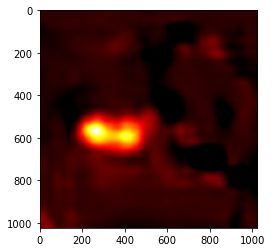

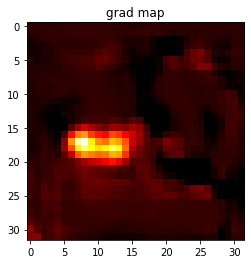

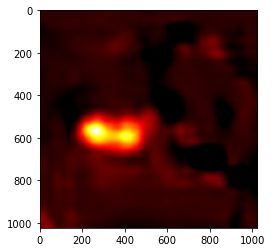

<Figure size 432x288 with 0 Axes>

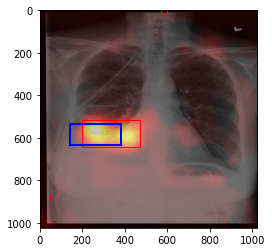

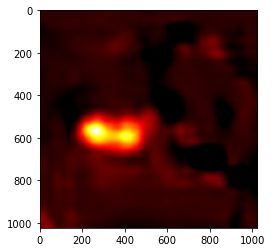

In [372]:
bbox_main(data_bb['AP']['Effusion'][30], gmodel, 'Effusion')

In [106]:
'''photos I want:
just skeleton,
just active map
upscale active map on skeleton
upscale with bb on skeleton
just bb on skeleton

new idea: compute by weight
'''

'photos I want:\njust skeleton,\njust active map\nupscale active map on skeleton\nupscale with bb on skeleton\njust bb on skeleton\n\nnew idea: compute by weight\n'

In [48]:
iobb_vals = []
for i in range(50):
    if i not in [-1]:
        iobb_vals.append(calc_iobb(data_bb['AP']['Effusion'][i], gmodel, 'Effusion'))
        print(i, ' : ', iobb_vals[i])

0  :  0.0
1  :  0.08234011501641851
2  :  0.0


/usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


3  :  0.027216581178687322
4  :  0.10819327731092437
5  :  0.07374491821877659
6  :  0.03769693159941854
7  :  0.04953302201467645
8  :  0.0
9  :  0.0
10  :  0.0
11  :  0.09408923198046425
12  :  0.003368794326241135
13  :  0.0
14  :  0.27649430530621855
15  :  0.1358897126969416
16  :  0.0
17  :  0.07491610120104229
18  :  0.049246865698565886
19  :  0.0
20  :  0.0
21  :  0.075308715018637
22  :  0.04450581895449452
23  :  0.0
24  :  0.12180638033420799
25  :  0.013767166985661999
26  :  0.08383233532934131
27  :  0.0
28  :  0.06050269513447908
29  :  0.46633645202715096
30  :  0.48901935203305064
31  :  0.0
32  :  0.0
33  :  0.0
34  :  0.5115454466833866
35  :  0.0807363527294541
36  :  0.0
37  :  0.09052459446637125
38  :  0.0
39  :  0.0
40  :  0.057725156035876884
41  :  0.07467472197377525
42  :  0.2672423336654489
43  :  0.058494020678361444
44  :  0.17007539556121906
45  :  0.12926740371765277
46  :  0.017274006234310777
47  :  0.0
48  :  0.22611321064738746
49  :  0.18276457681

In [49]:
iobb_vals.sort(reverse=True)

In [52]:
iobb_vals[0:10]

[0.5115454466833866,
 0.48901935203305064,
 0.46633645202715096,
 0.27649430530621855,
 0.2672423336654489,
 0.22611321064738746,
 0.18276457681714206,
 0.17007539556121906,
 0.1358897126969416,
 0.12926740371765277]

In [274]:
iobb_vals[0:10]

[0.5836963675682452,
 0.28625315446938504,
 0.26498839907192573,
 0.24668935643564358,
 0.21587103683634243,
 0.20769504348669535,
 0.17802574572203347,
 0.17402048563856456,
 0.16443300691821797,
 0.16224902104557012]

In [58]:
''' compute average size of boxes for each class:'''
def calc_area(d):
    return d['width'] * d['height']

avgs = copy.deepcopy(dis_small_map)
count = 0
for dis in dis_small_map.keys():
    avgs[dis] = 0
    for data_item in data_bb['AP'][dis]:
        avgs[dis] += calc_area(data_item)  
    avgs[dis] /= len(data_bb['AP'][dis])          

In [59]:
avgs

{'Cardiomegaly': 184334.51389042215,
 'Effusion': 72002.74056476016,
 'Mass': 44378.91808337311,
 'Nodule': 5468.77115036753,
 'Atelectasis': 33508.51688697086}

In [21]:
pkl_load = open('./dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("dataset for bounding box loaded in successfully")

dataset for bounding box loaded in successfully


In [277]:
bbox_results = {'AP' : {}, 'PA' : {}}

bbox_results['AP'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}
bbox_results['PA'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}

In [ ]:
for view in data_bb.keys():
    for disease in bbox_results['AP'].keys():
        for i in range(len(data_bb[view][disease])):
            bbox_results[view][disease].append(calc_iobb(data_bb[view][disease][i], gmodel, disease))
        print(view, disease, 'complete')

/usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


AP Cardiomegaly complete


In [48]:
data_bb.keys()

dict_keys(['AP', 'PA'])

In [57]:
for view in bbox_results.keys():
    for disease in bbox_results[view].keys():
        if bbox_results[view][disease]:
            mean = statistics.mean(bbox_results[view][disease])
            bbox_results[view][disease].sort()
            median = bbox_results[view][disease][len(bbox_results[view][disease]) // 2]
        print(view, disease, mean, median)
        print()

AP Cardiomegaly 0.1487217804768757 0.14913752590260934

AP Effusion 0.06917364005319358 0.05750243878191387

AP Mass 0.0336113380663053 0.015747674109975206

AP Nodule 0.00507850780219051 0.0043152350081037275

AP Atelectasis 0.03163882096697622 0.01921908096527521

PA Cardiomegaly 0.1487217804768757 0.14913752590260934

PA Effusion 0.06917364005319358 0.05750243878191387

PA Mass 0.0336113380663053 0.015747674109975206

PA Nodule 0.00507850780219051 0.0043152350081037275

PA Atelectasis 0.03163882096697622 0.01921908096527521



In [ ]:
'''
restructure:
compute iobb and gen bbox could go in the same function together
should all be 1 big thing

main
- generic stuff shared
- print out iobb
- display graph
'''